#  First resnet implementation for kavisar -  PyTorch

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import pandas as pd # added to handle accuracy annd loss history

from sklearn.metrics import confusion_matrix
import itertools


plt.ion()   # interactive mode



In [58]:
data_dir = 'data_v2'
model_dir = data_dir + '/pytorch_models'
plot_dir  = data_dir + '/pytorch_plots'
history_dir = data_dir + '/pytorch_history'


model_name = '7_1_resnet18_kavisar__2018_07_17_v3_7'

acc_loss_plot_name = 'acc_loss_plot_' + model_name
accuracy_plot_name = 'accuracy_plot_' + model_name
loss_plot_name = 'loss_plot_' + model_name

number_of_epochs = 1

In [5]:
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [6]:
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

In [7]:
if not os.path.exists(history_dir):
    os.mkdir(history_dir)

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [9]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}

In [10]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'validation']}

In [11]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
device.index

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    #history_df = pd.DataFrame(columns=['train_acc', 'train_loss', 'val_acc', 'val_loss'])
    history_tensor = torch.empty((num_epochs,4), device=device) #4- trai_acc, train_loss, val_acc, val_loss

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
       # epoch_train_acc = 0
       # epoch_train_loss = 0
       # epoch_val_acc = 0
       # epoch_val_loss = 0
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # Collecting data for making plots
            if phase=='train':
                history_tensor[epoch,0] = epoch_acc
                history_tensor[epoch,1] = epoch_loss
            if phase=='validation':
                history_tensor[epoch,2] = epoch_acc
                history_tensor[epoch,3] =epoch_loss

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

     #   epoch_df = pd.DataFrame([[epoch_train_acc.data,
      #                           epoch_train_loss,
      #                           epoch_val_acc.data,
      #                           epoch_val_loss]],columns=['train_acc', 'train_loss', 'val_acc', 'val_loss'])
        
       # history_df = history_df.append(epoch_df,ignore_index=True)
        print()
        
    

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history_tensor

In [29]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 8)

In [30]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

 ## Multi GPU - Training

In [31]:
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model_ft = nn.DataParallel(model_ft)

In [32]:
model_ft = model_ft.to(device)

In [48]:
model_ft, history_tensor = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------
train Loss: 0.4670 Acc: 0.8194
validation Loss: 0.3442 Acc: 0.8625

Epoch 1/1
----------
train Loss: 0.4055 Acc: 0.8379
validation Loss: 0.3120 Acc: 0.8688

Training complete in 1m 1s
Best val Acc: 0.868750


In [49]:
history_tensor

tensor([[ 0.8194,  0.4670,  0.8625,  0.3442],
        [ 0.8379,  0.4055,  0.8687,  0.3120]], device='cuda:0')

In [50]:
a = history_tensor.cpu().numpy()

In [51]:
a

array([[0.819375  , 0.46696794, 0.8625    , 0.3441571 ],
       [0.8379167 , 0.4054608 , 0.86875   , 0.31201977]], dtype=float32)

In [52]:
df = pd.DataFrame(a,columns=['train_acc', 'train_loss', 'val_acc', 'val_loss'])

In [53]:
df

,train_acc,train_loss,val_acc,val_loss
0,0.819375,0.466968,0.86250,0.344157
1,0.837917,0.405461,0.86875,0.312020


In [76]:
torch.save(model_ft.state_dict(), os.path.join(model_dir,model_name))

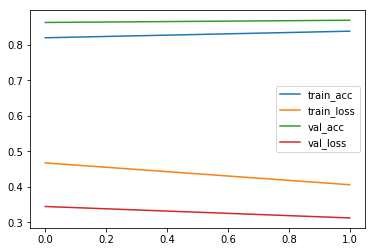

In [54]:
df.plot()

In [59]:
def plot_and_save_training_history(history_tensor):
    
    history_data = history_tensor.cpu().numpy()
    df = pd.DataFrame(history_data,columns=['train_acc', 'train_loss', 'val_acc', 'val_loss'])
    pie = df.plot()
    fig = pie.get_figure()
    fig.savefig(os.path.join(plot_dir, acc_loss_plot_name))
    
    

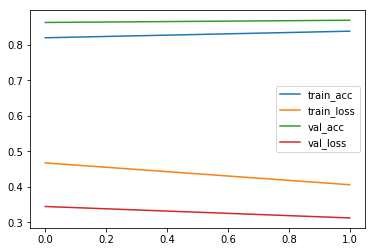

In [60]:
plot_and_save_training_history(history_tensor)

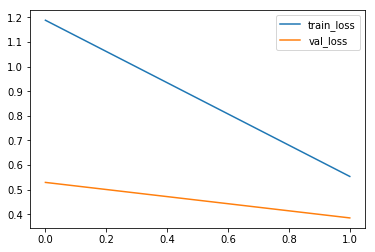

In [55]:
df.plot()

In [59]:
df

,train_acc,train_loss,val_acc,val_loss
0,"tensor(0.5737, dtype=torch.float64, device='cu...",1.188252,"tensor(0.8125, dtype=torch.float64, device='cu...",0.529685
1,"tensor(0.7846, dtype=torch.float64, device='cu...",0.553936,"tensor(0.8519, dtype=torch.float64, device='cu...",0.385468


In [64]:
df_loss = df[['train_loss','val_loss']]

In [65]:
df_loss

,train_loss,val_loss
0,1.188252,0.529685
1,0.553936,0.385468


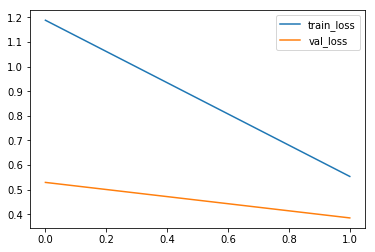

In [66]:
df_loss.plot()

In [67]:
df_acc = df[['train_acc','val_acc']]

In [68]:
df_acc.plot()

TypeError: Empty 'DataFrame': no numeric data to plot